# MH proposals for discrete Potts models

This notebook performs experiments with MCMC samplers from [Grathwohl et al. (2021)](https://arxiv.org/abs/2102.04509), [Zanella (2017)](https://arxiv.org/abs/1711.07424), and [Zhang et al. (2022)](https://arxiv.org/abs/2206.09914).

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import functools
import itertools
import math
from collections import Counter, defaultdict
from typing import Callable, Dict, Iterable, Iterator, List, Optional, Tuple

import numpy as np
import torch
import torch.distributions as dist
import pyro
import matplotlib
import matplotlib.pyplot as plt
from torch.distributions import constraints
from opt_einsum import contract as einsum
from pyro.ops.stats import autocorrelation
from pyro.ops.tensor_utils import convolve
from tqdm.auto import tqdm

matplotlib.rcParams.update({'figure.facecolor': "white"})
matplotlib.rcParams.update({'figure.dpi': 200})

Let's compare two of Zanella's balancing functions `g(-)`.

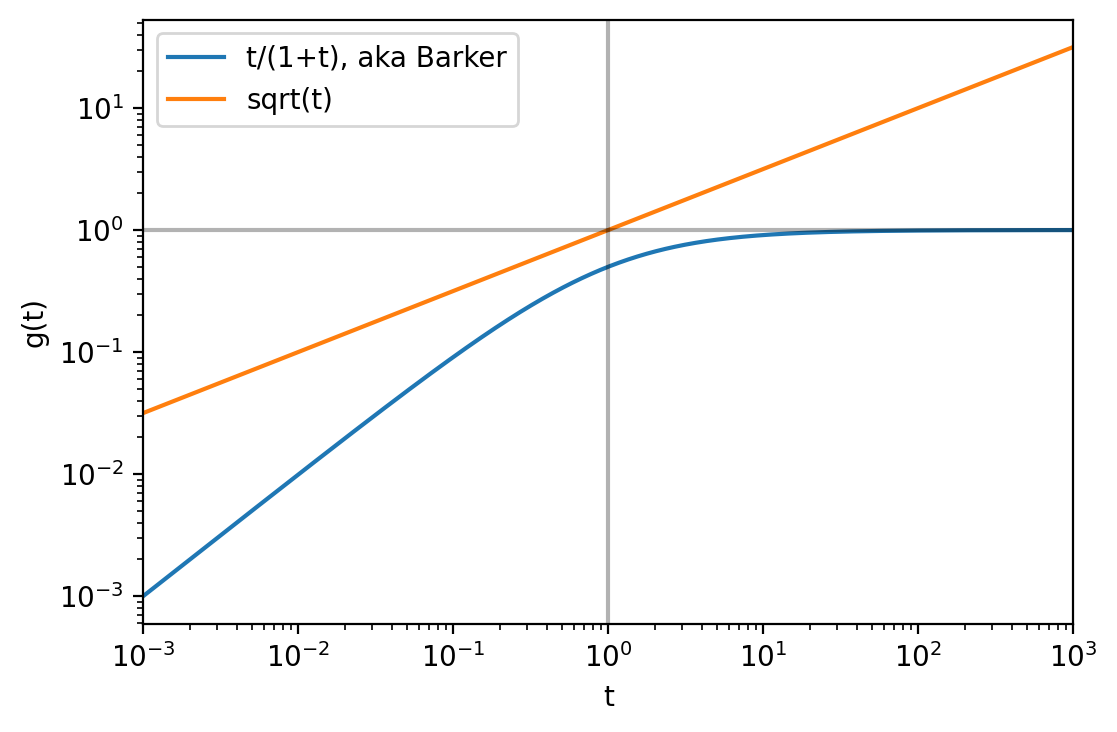

In [3]:
t = np.logspace(-3, 3,1000)
plt.plot(t, t / (1 + t), label="t/(1+t), aka Barker")
plt.plot(t, t ** 0.5, label="sqrt(t)")
plt.xlim(t.min(), t.max())
plt.xlabel("t")
plt.ylabel("g(t)")
plt.xscale("log")
plt.yscale("log")
plt.axvline(1, color="black", alpha=0.3)
plt.axhline(0, color="black", alpha=0.3)
plt.axhline(1, color="black", alpha=0.3)
plt.legend(loc="best");

Note that in log space where $x=\log(t)$, Barker's function becomes PyTorch's `logsigmoid` function:
$$
\log\circ(t\mapsto\frac t{1+t})\circ\exp = x\mapsto\log(\operatorname{sigmoid}(x))
$$
Similarly in log space, the sqrt function becomes
$$
  \log]\circ(t\mapsto\sqrt t)\circ\exp = x\mapsto x/2
$$

In [48]:
def balance_sqrt(logt):
    return logt / 2

def balance_barker(logt):
    return torch.nn.functional.logsigmoid(logt) + math.log(2)

def balance_global(logt):
    return logt

We assume all these functions preserve the log-odds normalization so that at the null hypothesis, `balanc(0) = 0`:

In [49]:
null_hypothesis = torch.tensor(0.)
for g in [balance_sqrt, balance_barker, balance_global]:
    assert torch.allclose(g(null_hypothesis), null_hypothesis)

Next consider a sparse Potts distribution class, where we implement a `.log_prob_nbhd()` method for locally-informed Metropolis-Hastings sampling.

In [50]:
class OneHotCategoricalPotts(dist.Distribution):
    arg_constraints = {
        "vertex_weights": constraints.independent(constraints.real, 2),
        "edge_weights": constraints.independent(constraints.real, 3),
    }
    support = constraints.independent(constraints.one_hot, 1)

    def __init__(
        self, vertex_weights: torch.Tensor, edge_weights: torch.Tensor, edges: torch.Tensor
    ):
        self.vertex_weights = vertex_weights
        self.edge_weights = edge_weights
        self.edges = edges
        assert edges.dim() == 2
        assert edges.shape[0] == 2
        assert all(len(set(edge)) == 2 for edge in edges.T.tolist()), "self edge"
        super().__init__(batch_shape=(), event_shape=vertex_weights.shape)

    def log_prob(self, x_onehot: torch.Tensor) -> torch.Tensor:
        """Returns non-normalized lob_prob."""
        if self._validate_args:
            assert x_onehot.dim() >= 2
            self._validate_sample(x_onehot)
        head, tail = x_onehot[..., self.edges, :]
        return (
            einsum("...vk,vk->...", x_onehot, self.vertex_weights)
            + einsum("...ej,...ek,ejk->...", head, tail, self.edge_weights)
        )

    def log_prob_nbhd(self, x_onehot: torch.Tensor) -> Tuple[float, torch.tensor]:
        """Assuming there are no self-edges (as asserted above),
        the gradient approximation of Grathwohl et al. (2021) is exact.
        """
        x_grad = x_onehot.clone().requires_grad_()
        log_prob = self.log_prob(x_grad)
        nbhd = torch.autograd.grad(log_prob, x_grad)[0].detach()
        nbhd -= (nbhd * x_onehot).sum(-1, True)
        assert not nbhd.requires_grad
        return log_prob.detach().item(), nbhd
    
    def enumerate_support(self):
        p, k = self.event_shape
        result = torch.zeros(k ** p, p, k)
        ks = [list(range(k))] * p
        for a, cs in enumerate(itertools.product(*ks)):
            for b, c in enumerate(cs):
                result[a, b, c] = 1
        return result

In [51]:
def random_potts(p: int=100, k: int=20, density: float=0.1, temperature: float=2):
    P = torch.arange(p)
    e = p * (p - 1) // 2
    complete_edges = torch.stack([
        P[:, None].expand(p, p), P.expand(p, p)
    ], 0).reshape(2, p * p)
    complete_edges = complete_edges[:, complete_edges[0] < complete_edges[1]]
    assert complete_edges.shape == (2, e)
    complete_edges = complete_edges[:, torch.randperm(e)]
    edges = complete_edges[:, :round(density * e)].clone()
    vertex_weights = torch.randn(p, k) / temperature
    edge_weights = torch.randn(edges.shape[1], k, k) / temperature
    return OneHotCategoricalPotts(vertex_weights, edge_weights, edges)

In [52]:
def test_enumerate_support(p, k, expected):
    actual = random_potts(p, k).enumerate_support().tolist()
    assert actual == expected
    
test_enumerate_support(
    2, 2,
    [
        [[1, 0], [1, 0]],
        [[1, 0], [0, 1]],
        [[0, 1], [1, 0]],
        [[0, 1], [0, 1]],
    ],
)
    
test_enumerate_support(
    2, 3,
    [
        [[1, 0, 0], [1, 0, 0]],
        [[1, 0, 0], [0, 1, 0]],
        [[1, 0, 0], [0, 0, 1]],
        [[0, 1, 0], [1, 0, 0]],
        [[0, 1, 0], [0, 1, 0]],
        [[0, 1, 0], [0, 0, 1]],
        [[0, 0, 1], [1, 0, 0]],
        [[0, 0, 1], [0, 1, 0]],
        [[0, 0, 1], [0, 0, 1]],
    ],
)

In [53]:
def gibbs_with_gradients(
    d: OneHotCategoricalPotts, g: callable
) -> Iterator[Tuple[torch.Tensor, int]]:
    # Initialize to random uniform.
    p, k = d.event_shape
    x0 = torch.zeros(p, k)
    x0[torch.arange(p), torch.randint(0, k - 1, (p,))] = 1
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = g(nbhd).clamp(max=torch.finfo(nbhd.dtype).max)
    logq0 -= logq0.reshape(-1).logsumexp(0)  # normalize

    while True:
        # Propose.
        ij = dist.Categorical(logits=logq0.reshape(-1)).sample().item()
        i, j1 = divmod(ij, k)
        x1 = x0.clone()
        x1[i] = 0
        x1[i, j1] = 1
        j0 = int(x0[i].max(0).indices)
        if j1 == j0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = g(nbhd)
        logq1 -= logq1.reshape(-1).logsumexp(0)  # normalize
        ratio = (logp1 - logp0 + logq1[i, j0] - logq0[i, j1]).exp()
        accept = int(ratio > torch.rand(()))
        if accept:
            x0, logp0, logq0 = x1, logp1, logq1
        yield x0, accept

In [54]:
def discrete_langevin(
    d: OneHotCategoricalPotts, g: callable, stepsize:float = 1.0
) -> Iterator[Tuple[torch.Tensor, int]]:
    """Implements DMALA = Metropolis-Hastings with discrete Langevin proposals
    from Zhang et al. (2022) https://arxiv.org/abs/2206.09914.
    """
    # Initialize to random uniform.
    x0 = dist.OneHotCategorical(torch.ones(d.event_shape)).sample()
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = g(nbhd).clamp(max=math.log(1e6))
    logq0 += x0 / stepsize
    logq0 -= logq0.logsumexp(-1, True)  # normalize

    while True:
        # Propose.
        x1 = dist.OneHotCategorical(logits=logq0).sample()
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = g(nbhd)
        logq1 += x1 / stepsize
        logq1 -= logq1.logsumexp(-1, True)  # normalize
        ratio = (logp1 - logp0 + torch.tensordot(logq1, x0) - torch.tensordot(logq0, x1)).exp()
        if ratio > torch.rand(()):
            x0, logp0, logq0 = x1, logp1, logq1
        else:
            distance = 0
        yield x0, distance

In [55]:
def adaptive_langevin(
    d: OneHotCategoricalPotts, g: callable, max_stepsize: float = 0.5
) -> Iterator[Tuple[torch.Tensor, int]]:
    assert 0 < max_stepsize < 1
    def make_logq(x, nbhd):
        logq = g(nbhd).clamp(max=math.log(1e6))
        # Set step size so that q(x1[i] != x0[i]) <= max_stepsize for every i.
        Q = logq.exp().sum(-1).max()
        q = Q.sub(1).mul((1 - max_stepsize) / max_stepsize).clamp(min=1)
        logq += x * q.log()
        logq -= logq.logsumexp(-1, True)  # normalize
        return logq
        
    # Initialize to random uniform.
    x0 = dist.OneHotCategorical(torch.ones(d.event_shape)).sample()
    logp0, nbhd = d.log_prob_nbhd(x0)
    logq0 = make_logq(x0, nbhd)

    while True:
        # Propose.
        x1 = dist.OneHotCategorical(logits=logq0).sample()
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            yield x0, 0
            continue

        # Accept or reject.
        logp1, nbhd = d.log_prob_nbhd(x1)
        logq1 = make_logq(x1, nbhd)
        ratio = (logp1 - logp0 + torch.tensordot(logq1, x0) - torch.tensordot(logq0, x1)).exp()
        if ratio > torch.rand(()):
            x0, logp0, logq0 = x1, logp1, logq1
        else:
            distance = 0
        yield x0, distance

## Testing the sampler

Let's quick test that the sampler draws correct samples.

In [56]:
def one_hot_to_hashable(x_onehot: torch.Tensor) -> Tuple[int]:
    assert x_onehot.dim() == 2
    assert (x_onehot.sum(-1) == 1).all()
    return tuple(x_onehot.max(-1).indices.tolist())

In [57]:
def get_histogram(n, d, g, mcmc):
    hist = Counter()
    distances = Counter()
    for i, (x, distance) in enumerate(mcmc(d, g)):
        hist[one_hot_to_hashable(x)] += 1
        if i >= n:
            break
        distances[distance] += 1
    mean = sum(k * v for k, v in distances.items()) / sum(distances.values())
    print(f"mean distance = {mean:0.3f}")
    return hist

In [58]:
def sample_efficiency(counts: torch.Tensor, probs: torch.Tensor) -> float:
    assert counts.sum() > probs.sum()
    total = counts.sum()
    chisq = (counts - total * probs).square().sum().div(total)
    return float(1 / chisq)

In [59]:
print(sample_efficiency(torch.tensor([99, 101]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([90, 110]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([9900, 10100]), torch.tensor([0.5, 0.5])))
print(sample_efficiency(torch.tensor([80, 120]), torch.tensor([0.5, 0.5])))

100.0
1.0
1.0
0.25


In [60]:
def test_gof(mcmc, p, k, g=balance_sqrt, n=20000):
    pyro.set_rng_seed(20220709)
    d = random_potts(p, k, density=0.9)
    hist = get_histogram(n, d, g=g, mcmc=mcmc)
    xs = d.enumerate_support()
    log_probs = {one_hot_to_hashable(x): float(d.log_prob(x)) for x in xs}  # non-normalized
    log_total = float(torch.tensor(list(log_probs.values())).logsumexp(-1))
    probs_dict = {k: math.exp(v - log_total) for k, v in log_probs.items()}
    keys = sorted(probs_dict)
    probs = torch.tensor([probs_dict[k] for k in keys])
    probs, indices = probs.sort(0, descending=True)
    counts = torch.tensor([hist.pop(k, 0) for k in keys])[indices]
    assert not hist, f"invalid samples: {set(hist)}"
    eff = sample_efficiency(counts, probs)
    plt.figure(figsize=(6, 3))
    plt.plot(probs, "k--", label="truth")
    plt.plot(counts / counts.sum(), label="empirical")
    plt.ylabel("probability")
    plt.xlabel("rank")
    plt.legend(loc="best")
    plt.title(f"{mcmc.__name__}({g.__name__}) efficiency = {eff:0.4g}")
    plt.tight_layout()

mean distance = 0.390
mean distance = 0.530
mean distance = 0.592


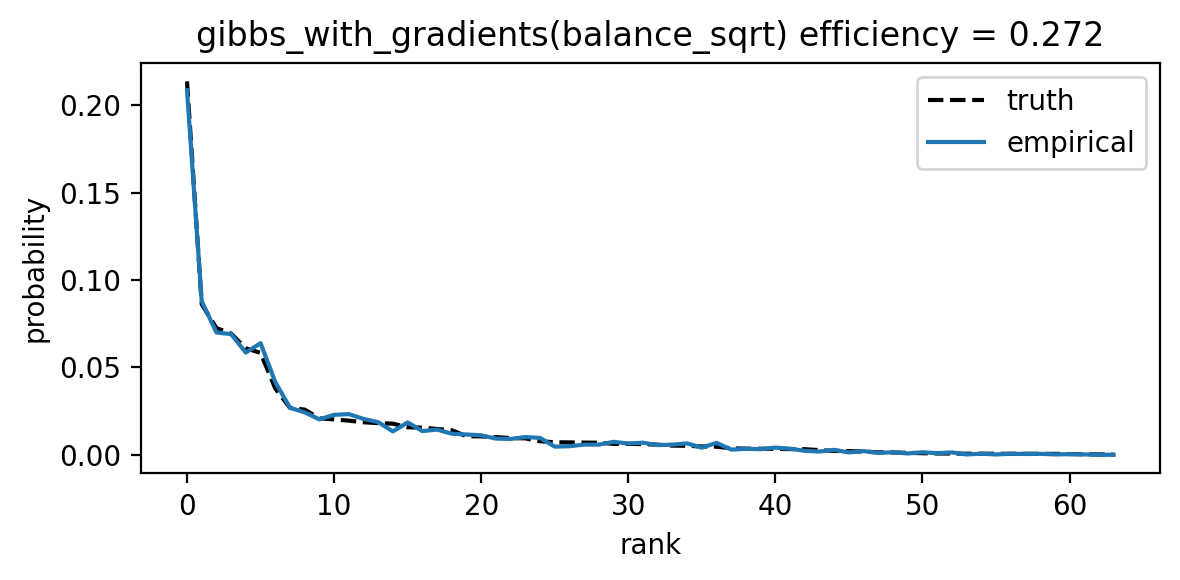

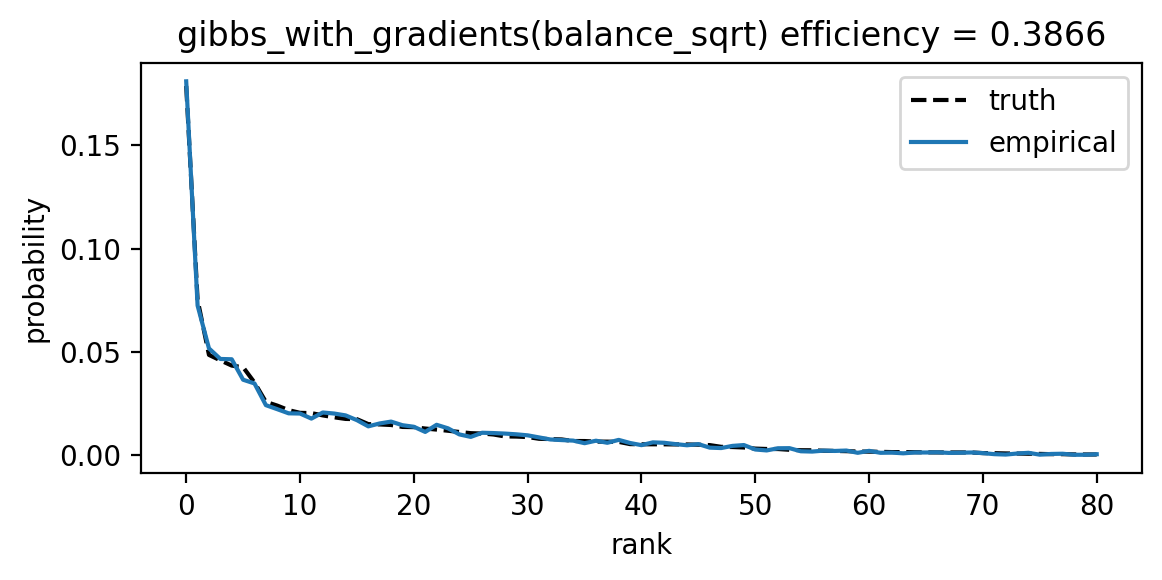

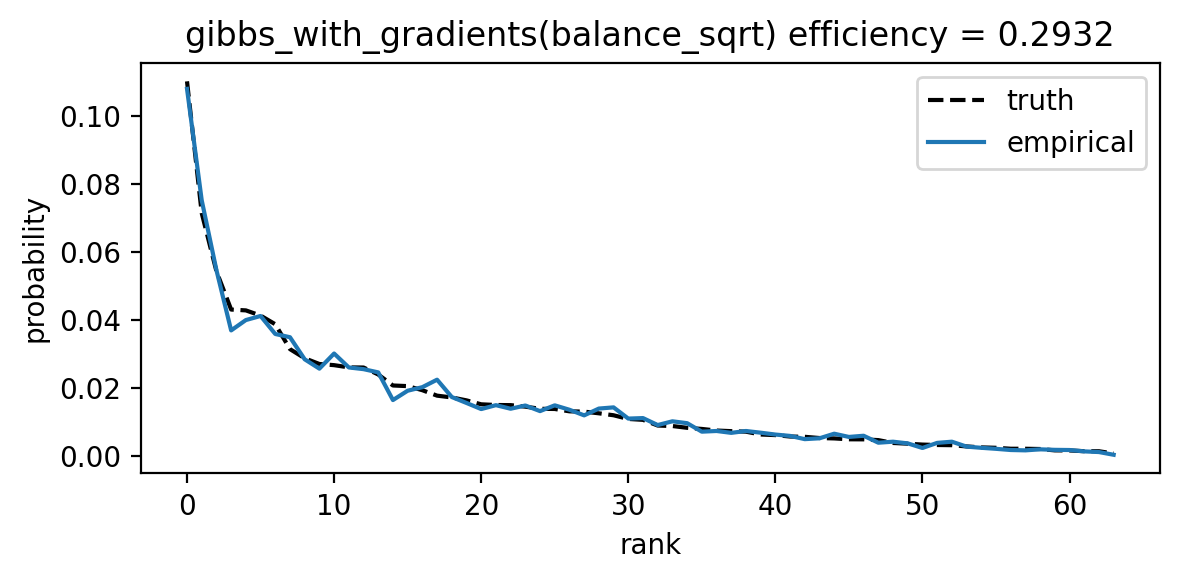

In [61]:
test_gof(gibbs_with_gradients, 6, 2)
test_gof(gibbs_with_gradients, 4, 3)
test_gof(gibbs_with_gradients, 3, 4)

mean distance = 0.889
mean distance = 0.974
mean distance = 0.934


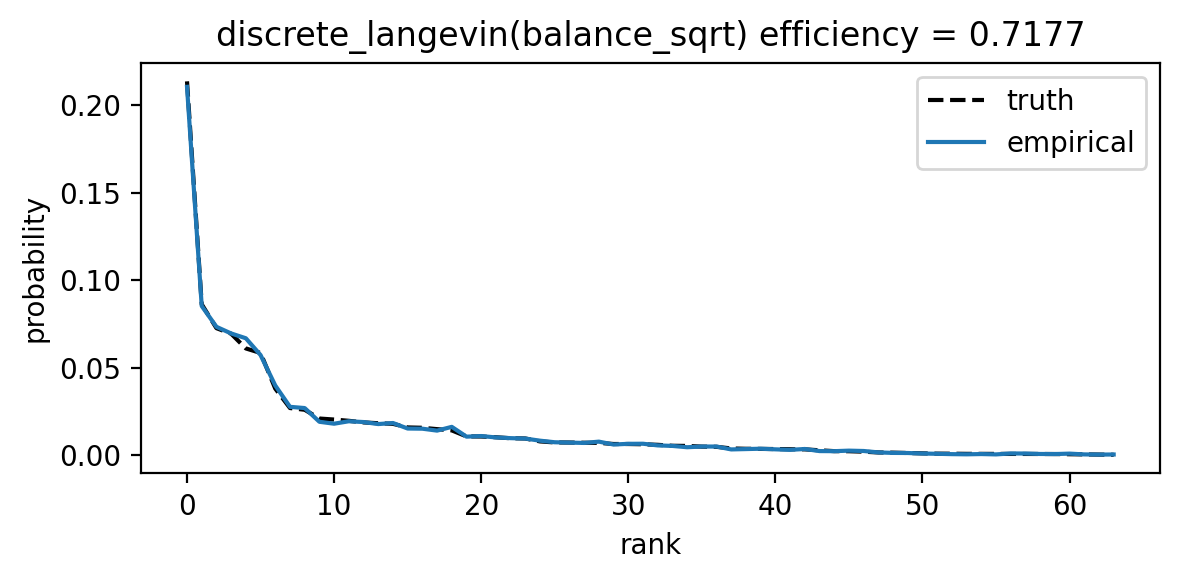

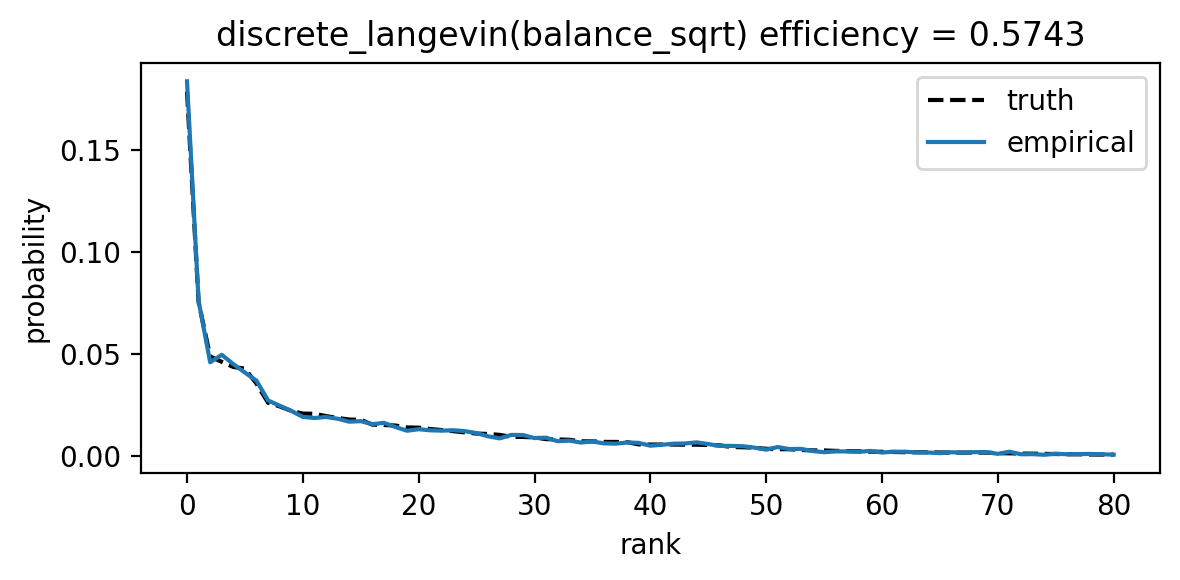

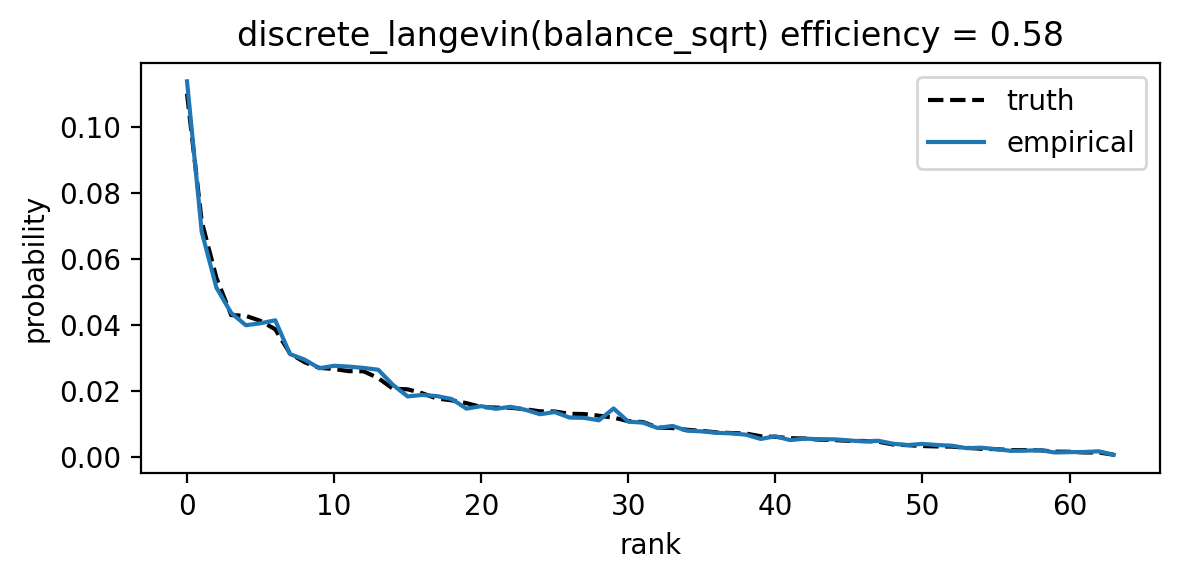

In [62]:
test_gof(discrete_langevin, 6, 2)
test_gof(discrete_langevin, 4, 3)
test_gof(discrete_langevin, 3, 4)

mean distance = 0.889
mean distance = 0.870
mean distance = 0.775


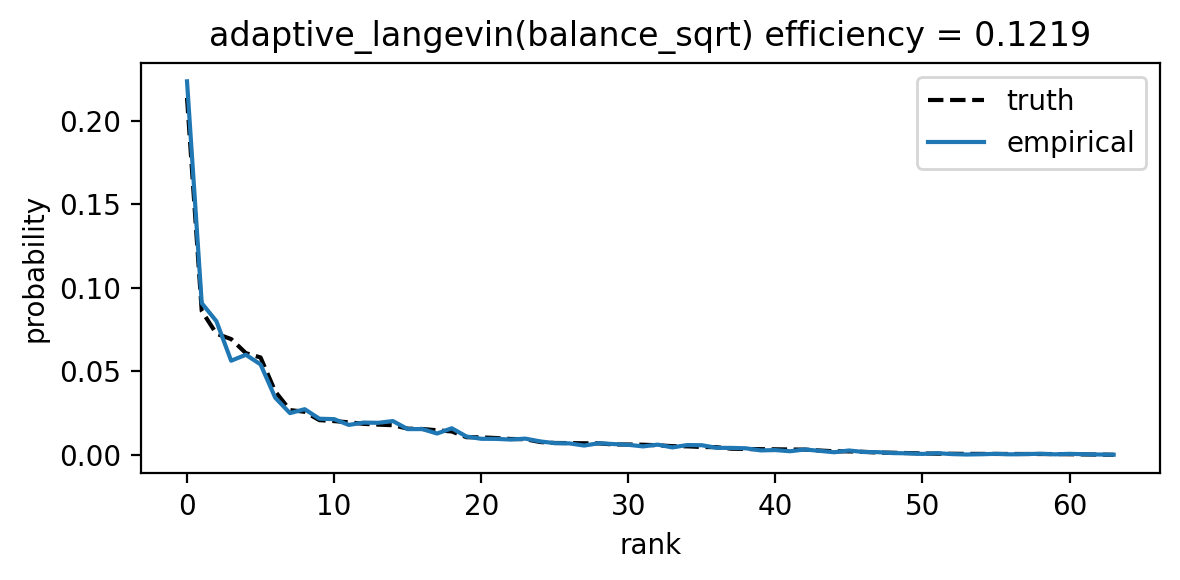

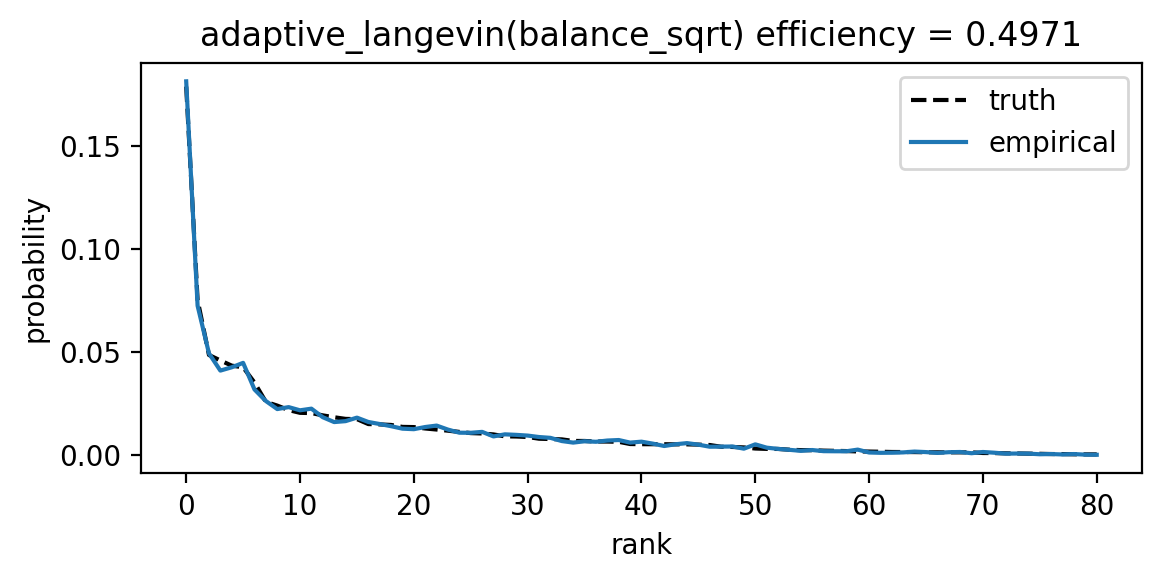

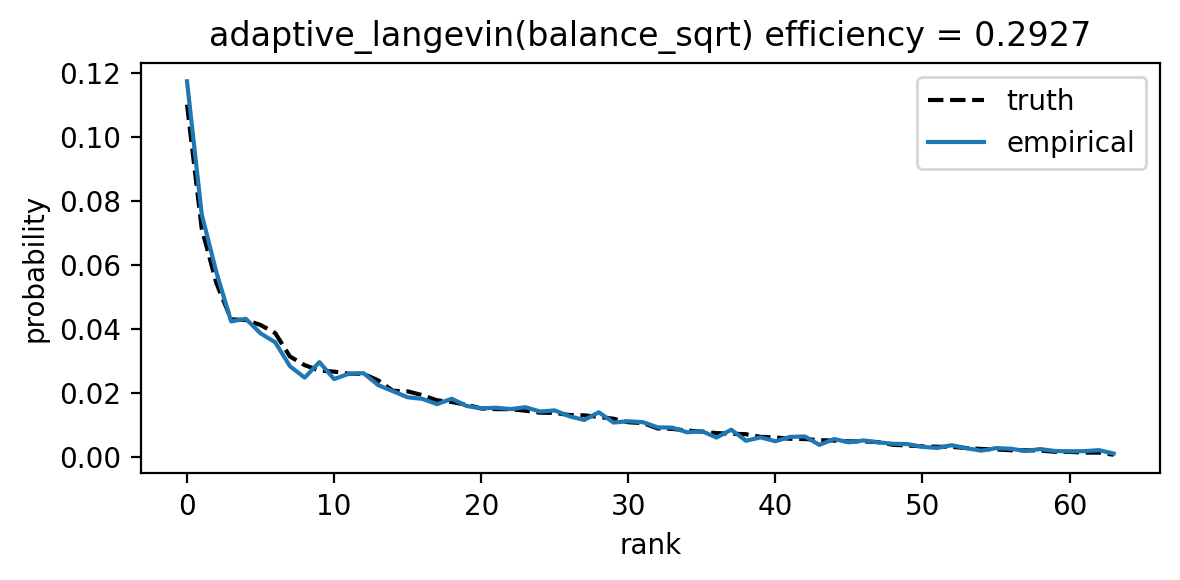

In [63]:
test_gof(adaptive_langevin, 6, 2)
test_gof(adaptive_langevin, 4, 3)
test_gof(adaptive_langevin, 3, 4)

mean distance = 0.979
mean distance = 0.920
mean distance = 0.776


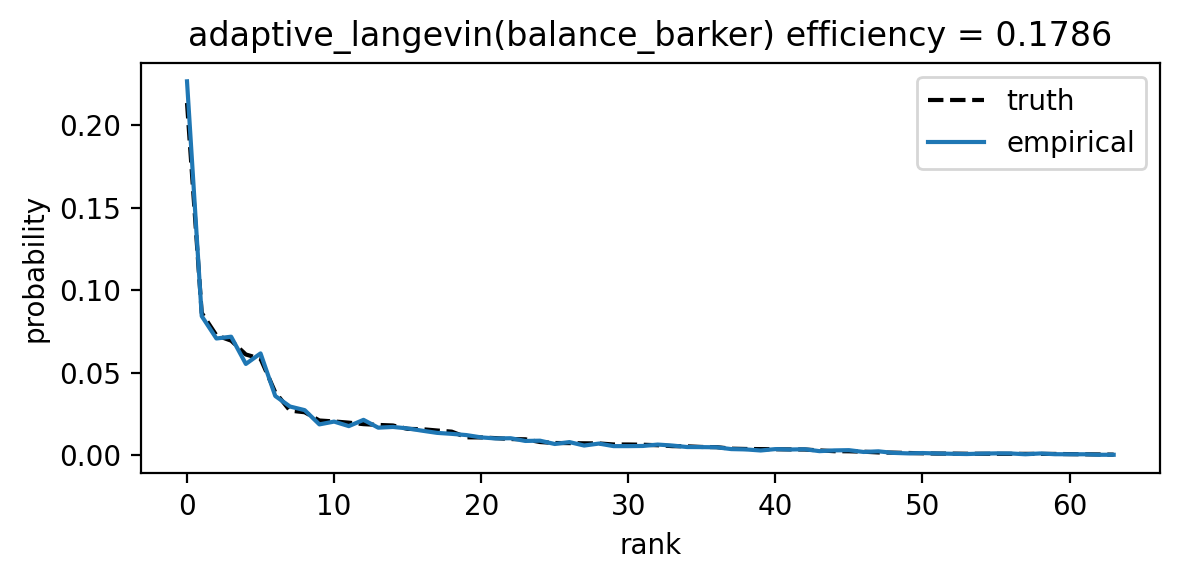

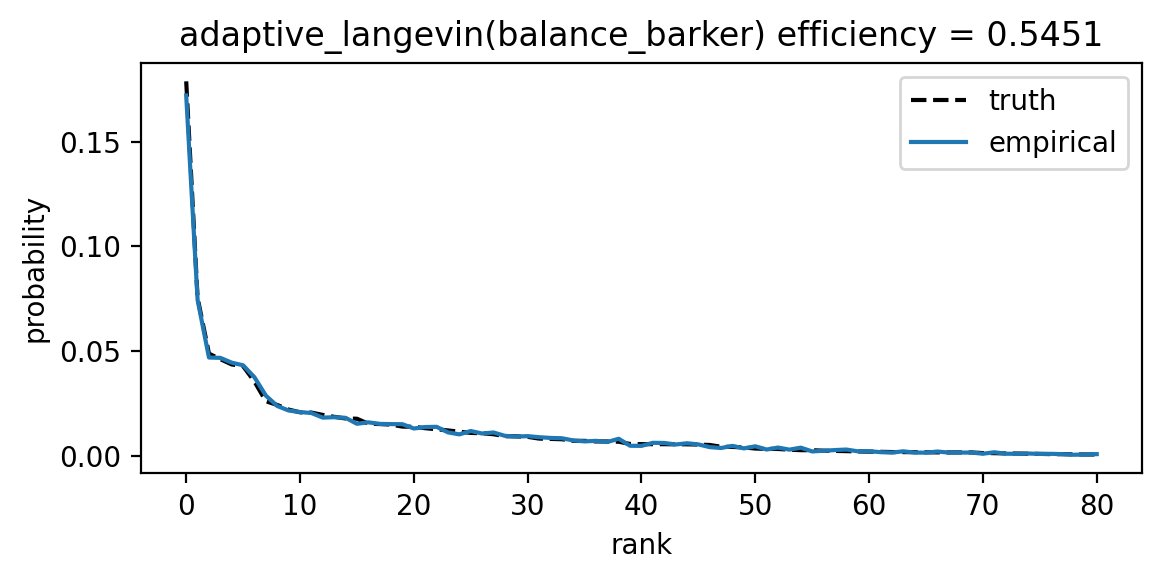

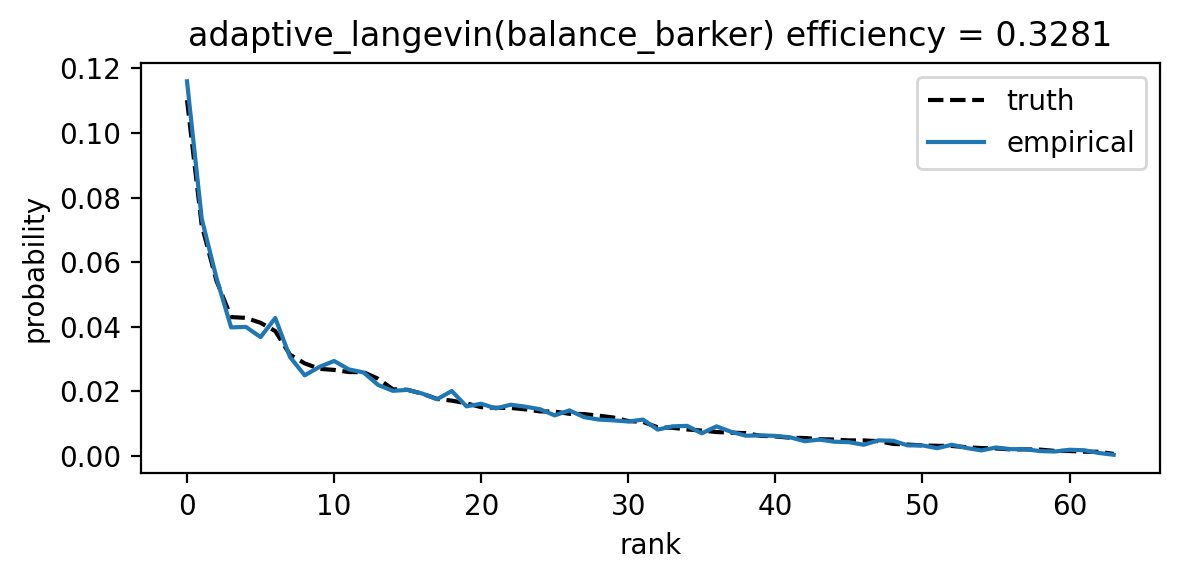

In [64]:
test_gof(adaptive_langevin, 6, 2, g=balance_barker)
test_gof(adaptive_langevin, 4, 3, g=balance_barker)
test_gof(adaptive_langevin, 3, 4, g=balance_barker)

mean distance = 0.739
mean distance = 0.719
mean distance = 0.721


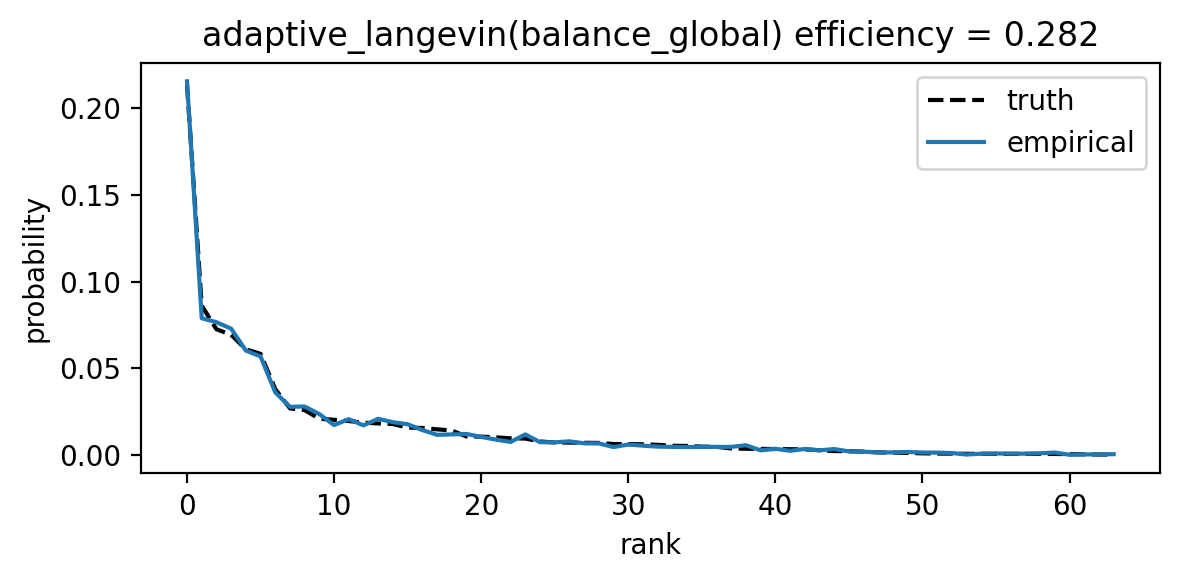

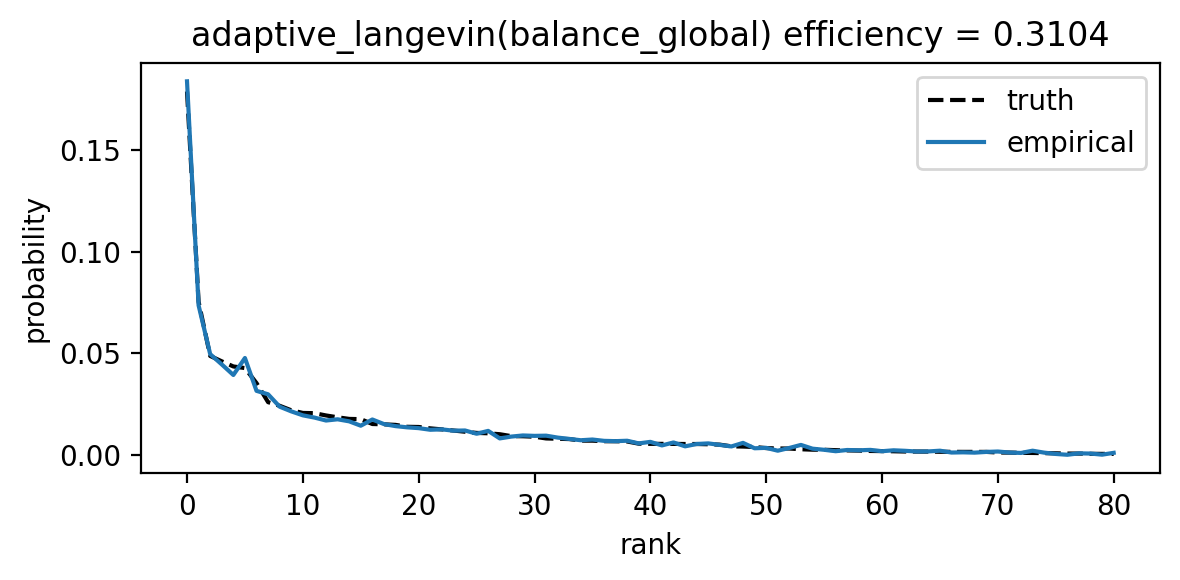

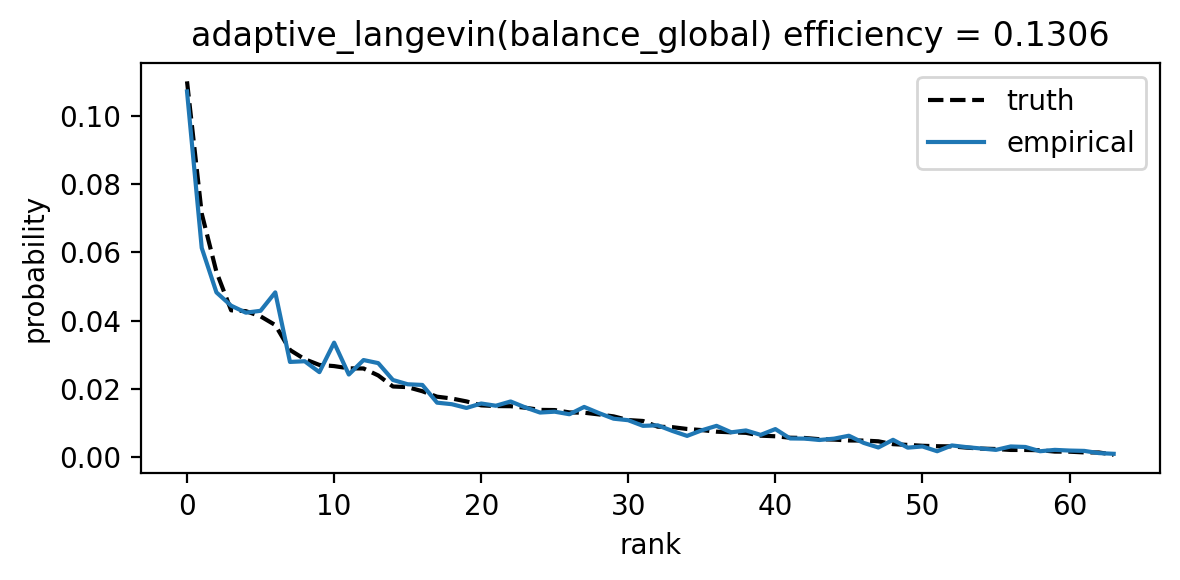

In [65]:
test_gof(adaptive_langevin, 6, 2, g=balance_global)
test_gof(adaptive_langevin, 4, 3, g=balance_global)
test_gof(adaptive_langevin, 3, 4, g=balance_global)

## Comparing balancing functions

In [66]:
def get_trace(p: int, k: int, n: int, g: callable, mcmc: callable, seed=20220708):
    pyro.set_rng_seed(seed)
    d = random_potts(p, k)
    xs = []
    distances = Counter()
    for i, (x, distance) in enumerate(mcmc(d, g)):
        xs.append(x)
        distances[distance] += 1
        if i >= n:
            break
    mean = sum(k * v for k, v in distances.items()) / sum(distances.values())
    print(f"mean distance = {mean:0.3f}")
    return torch.stack(xs)

In [67]:
def eff(a: torch.Tensor) -> float:
    """Computes sample efficiency from autocorrelation."""
    # https://mc-stan.org/docs/2_21/reference-manual/effective-sample-size-section.html
    cutoff = 1 + 10 * a[:len(a) // 2].abs().gt(0.5).long().sum().item()
    a = a[1:cutoff]  # lag 1 up to cutoff
    return 1 / (1 + 2 * a.sum().item())

def plot_autocorrelation(p, k, s=2000):
    mcmcs = [
        ("Gibbs w/ Grads", gibbs_with_gradients, "g"),
        ("Langevin-stepsize-1", discrete_langevin, "b"),
        ("Langevin-adaptive-1/2", adaptive_langevin, "darkred"),
        ("Langevin-adaptive-1/5", functools.partial(adaptive_langevin, max_stepsize=0.2), "pink"),
    ]
    gs = [
        ("sqrt", balance_sqrt, "--"),
        ("Barker", balance_barker, ":"),
        ("global", balance_global, "-"),
    ]
    plt.figure(figsize=(8, 5))
    plt.title(f"{p}-length sequences of {k}-sized alphabet")
    x = np.arange(1, 1 + s // 2)
    effs = []
    for mcmc_name, mcmc, color in mcmcs:
        for g_name, g, linestyle in gs:
            tr = get_trace(p, k, s, g=g, mcmc=mcmc)
            a = autocorrelation(tr, dim=0).mean([1,2])
            effs.append(eff(a))
            plt.plot(x, a[:s // 2], label=f"{mcmc_name} ({g_name}) eff = {effs[-1]:0.3g}",
                     color=color, linestyle=linestyle)
    plt.ylabel("autocorrelation")
    plt.xlabel("1 + lag")
    plt.xlim(1, None)
    plt.xscale("log")
    legend = plt.legend(loc="upper right", fontsize=8)
    for t, e in zip(legend.get_texts(), effs):
        if e == max(effs):
            t.set_weight("bold")

mean distance = 0.488
mean distance = 0.487
mean distance = 0.431
mean distance = 1.156
mean distance = 1.176
mean distance = 1.074
mean distance = 1.588
mean distance = 1.682
mean distance = 1.415
mean distance = 0.688
mean distance = 0.719
mean distance = 0.574


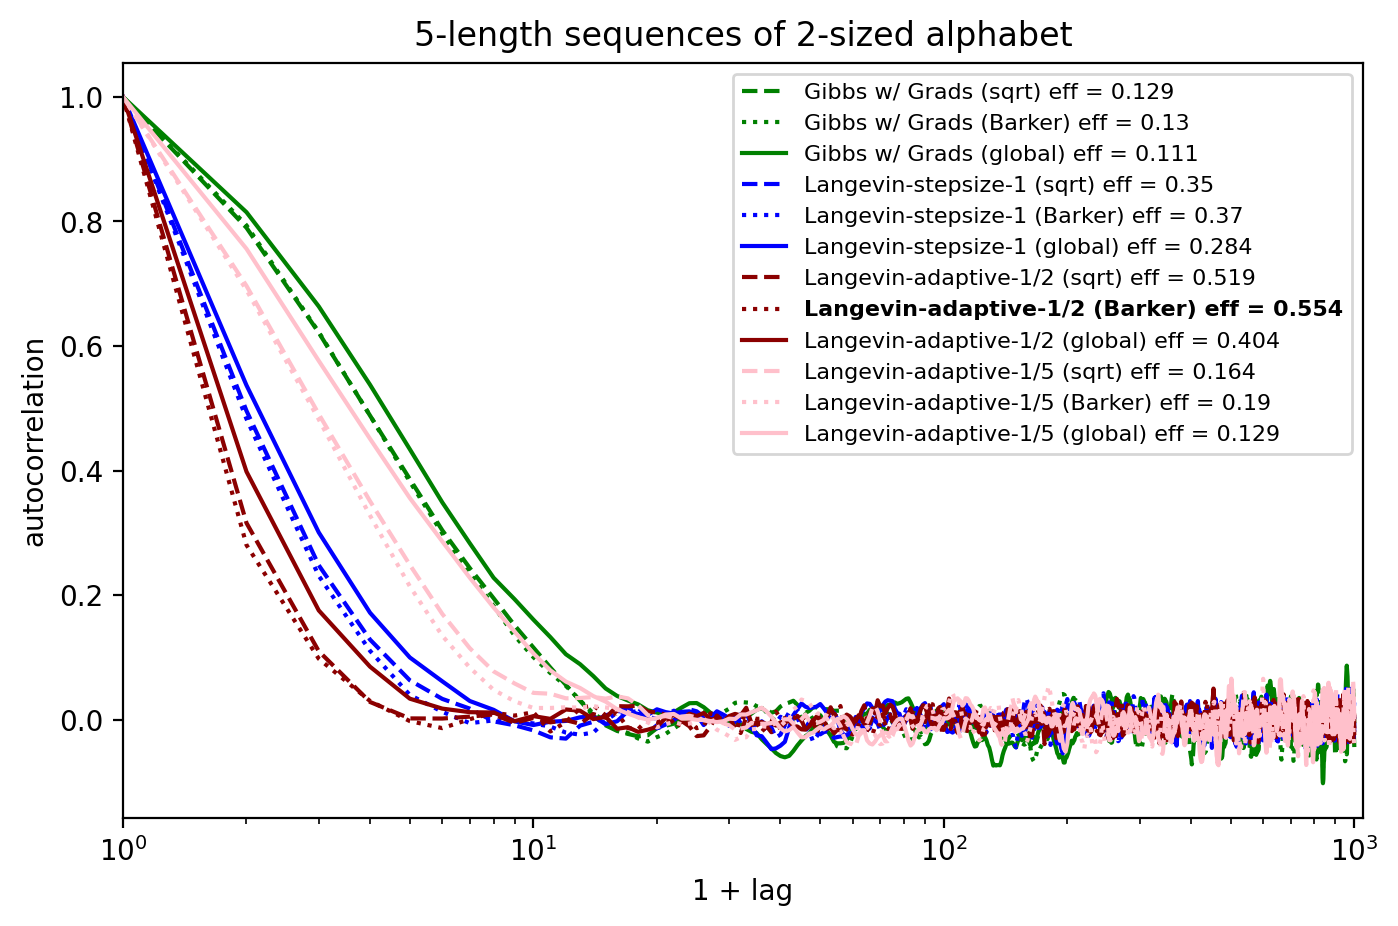

In [68]:
plot_autocorrelation(5, 2)

mean distance = 0.700
mean distance = 0.689
mean distance = 0.491
mean distance = 3.071
mean distance = 3.157
mean distance = 3.337
mean distance = 2.466
mean distance = 2.736
mean distance = 1.665
mean distance = 1.080
mean distance = 1.192
mean distance = 0.626


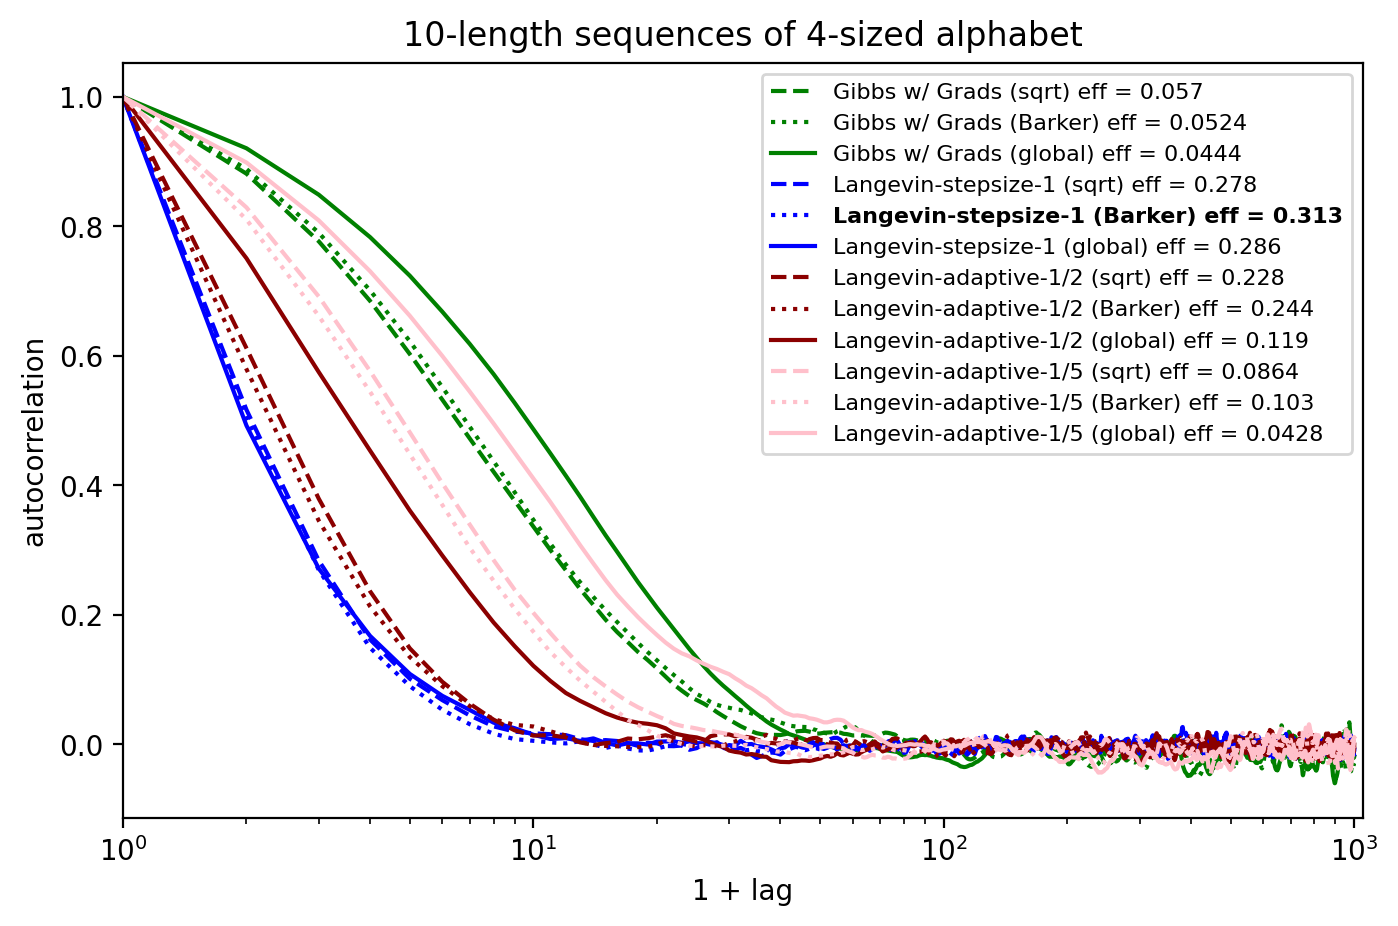

In [69]:
plot_autocorrelation(10, 4)

mean distance = 0.825
mean distance = 0.824
mean distance = 0.498
mean distance = 3.586
mean distance = 3.618
mean distance = 6.115
mean distance = 3.794
mean distance = 4.292
mean distance = 1.849
mean distance = 1.795
mean distance = 2.038
mean distance = 0.601


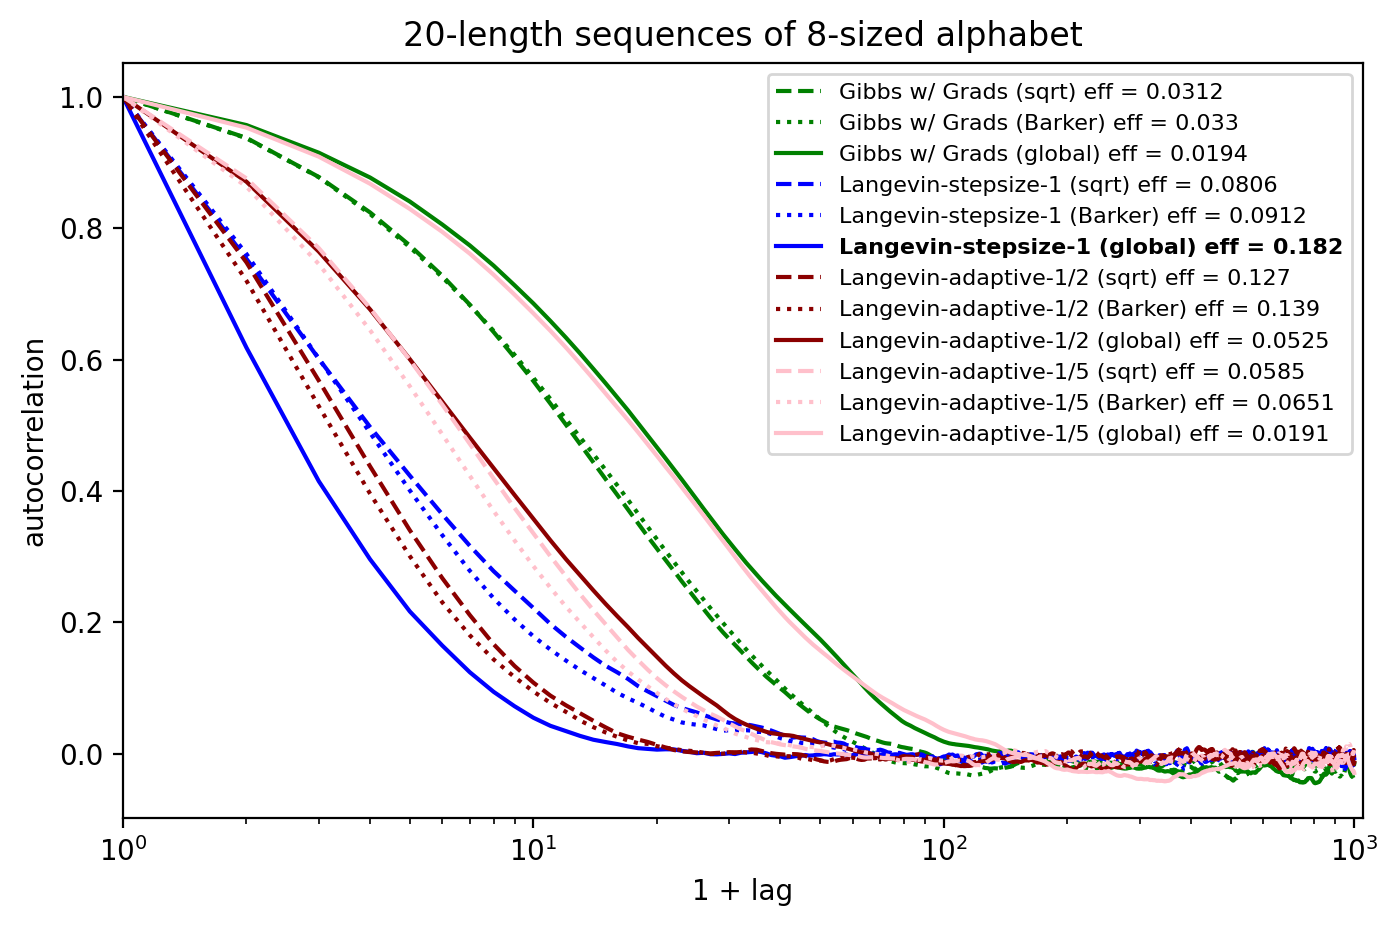

In [70]:
plot_autocorrelation(20, 8)

mean distance = 0.917
mean distance = 0.907
mean distance = 0.377
mean distance = 0.645
mean distance = 0.330
mean distance = 0.806
mean distance = 4.723
mean distance = 5.030
mean distance = 0.697
mean distance = 2.601
mean distance = 3.432
mean distance = 0.344


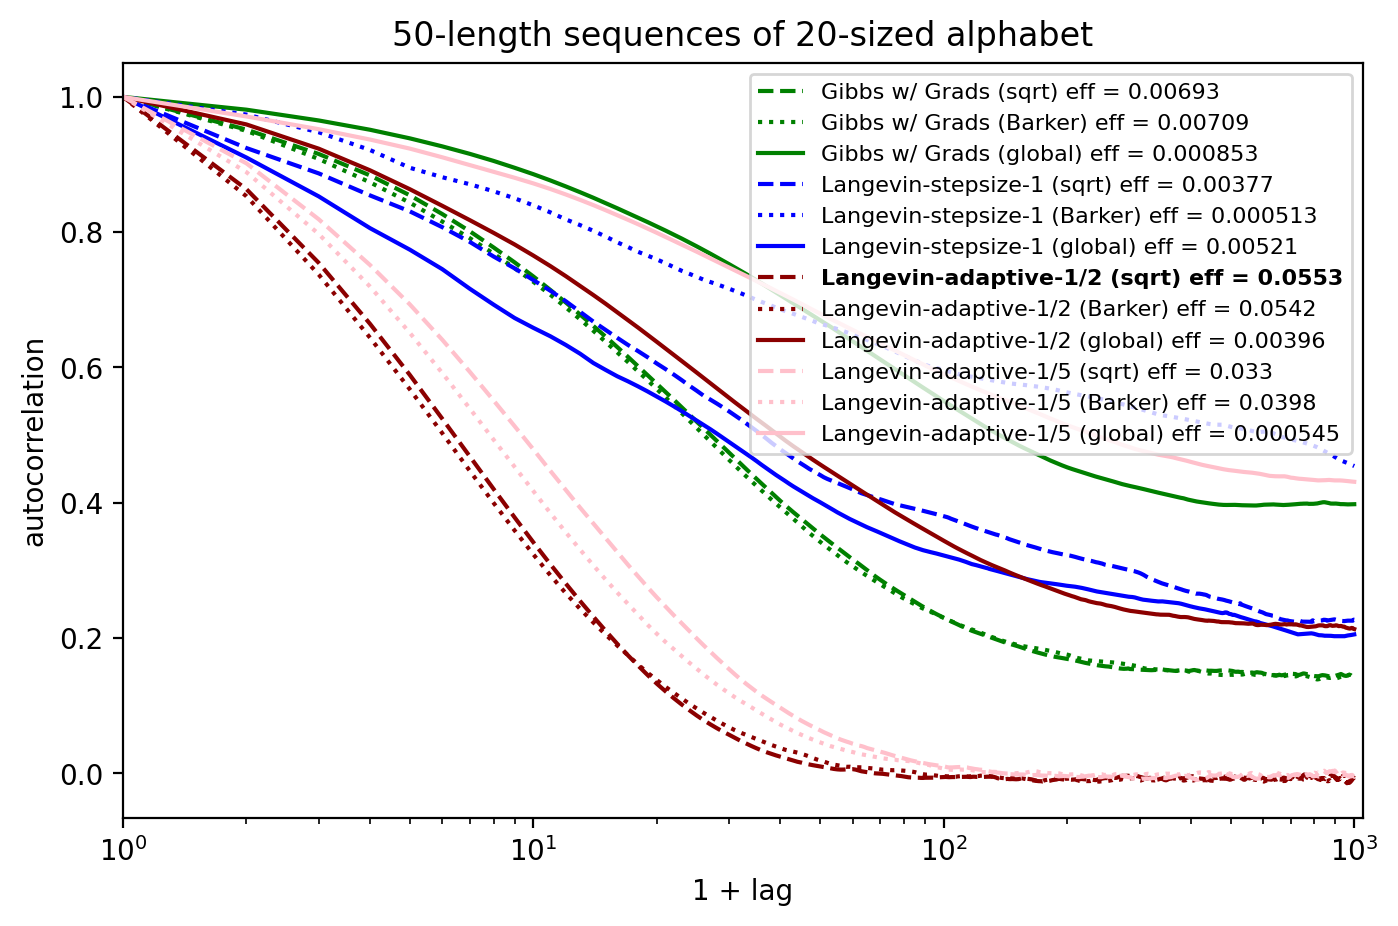

In [71]:
plot_autocorrelation(50, 20)

mean distance = 0.896
mean distance = 0.872
mean distance = 0.255
mean distance = 0.104
mean distance = 0.028
mean distance = 0.096
mean distance = 4.250
mean distance = 4.359
mean distance = 0.188
mean distance = 2.992
mean distance = 4.194
mean distance = 0.183


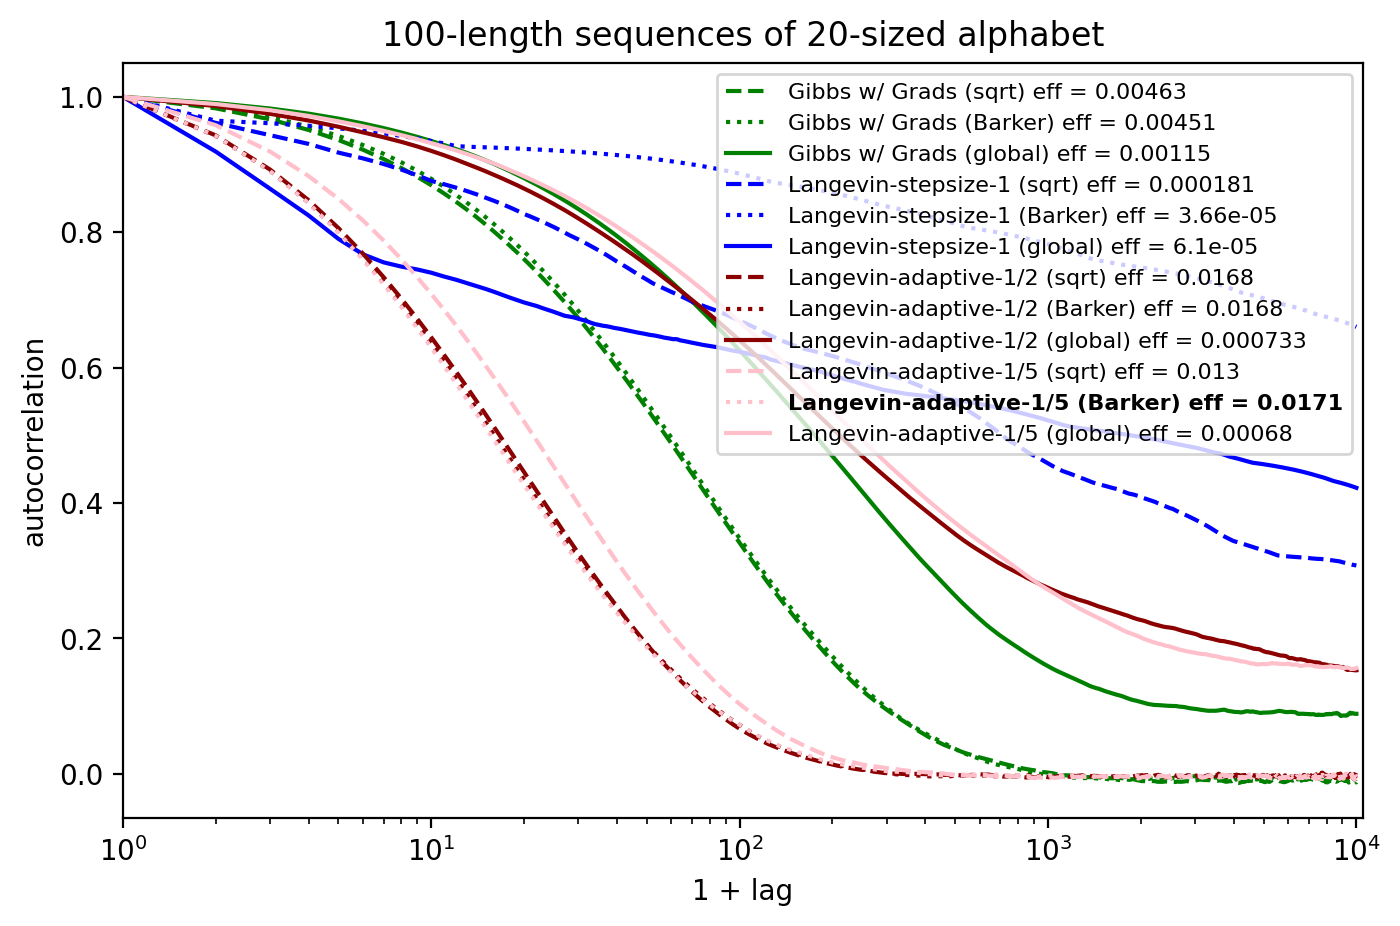

In [72]:
plot_autocorrelation(100, 20, 20000)

mean distance = 0.451
mean distance = 0.337
mean distance = 0.001
mean distance = 0.118
mean distance = 0.294
mean distance = 0.081
mean distance = 2.520
mean distance = 2.593
mean distance = 0.000
mean distance = 2.245
mean distance = 4.521
mean distance = 0.001


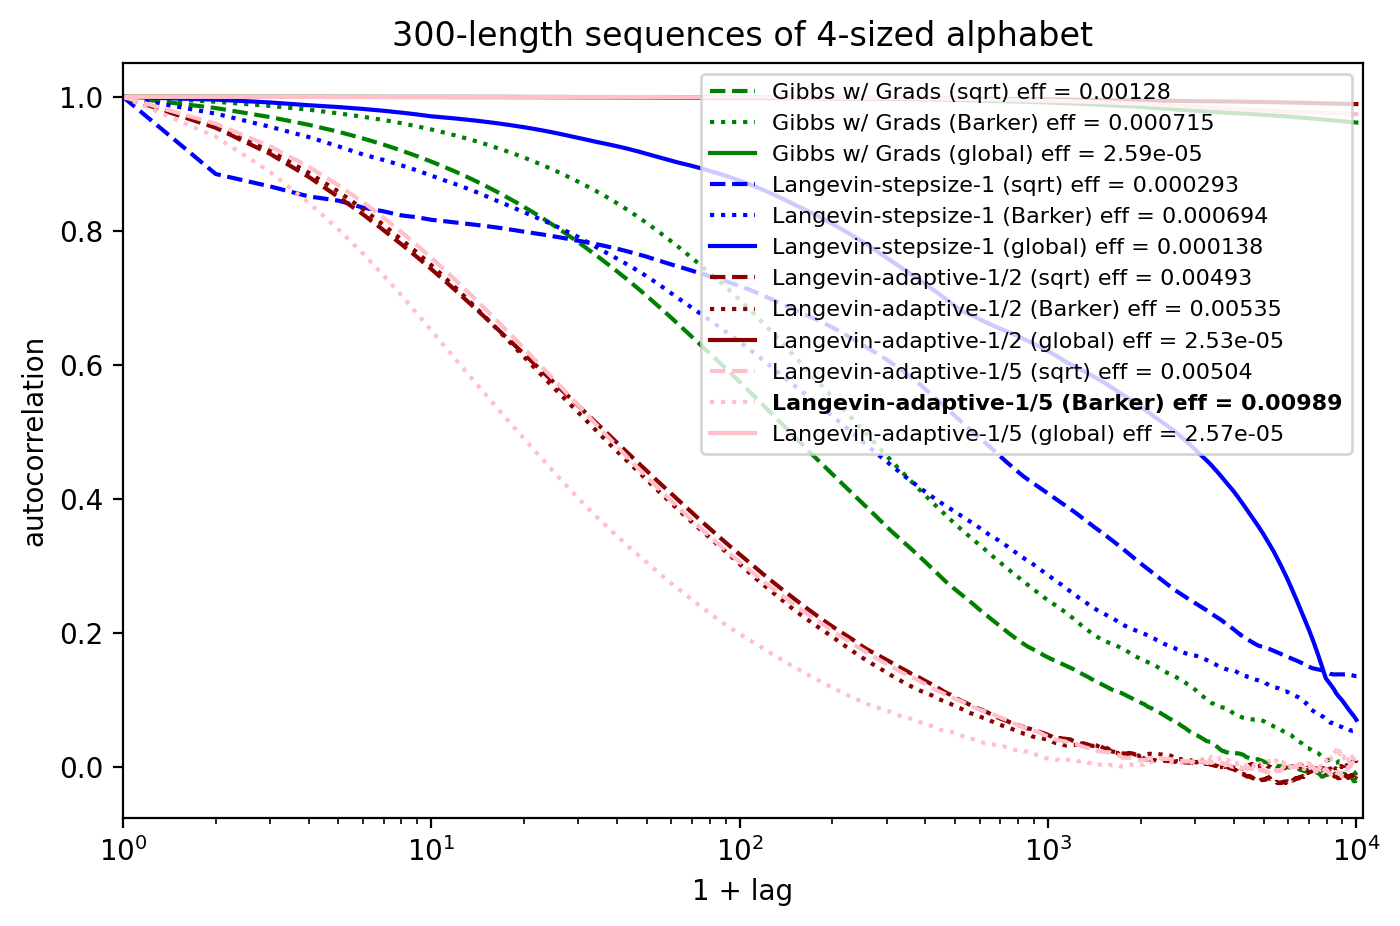

In [73]:
plot_autocorrelation(300, 4, 20000)

## Comparison across temperatures

In [74]:
def get_eff(p: int, k: int, g: callable, mcmc: callable, temperature: float, n=10000):
    d = random_potts(p, k, temperature=temperature)
    xs = []
    for i, (x, _) in enumerate(mcmc(d, g=g)):
        xs.append(x)
        if i >= n:
            break
    x = torch.stack(xs)
    a = autocorrelation(x, dim=0).mean([1,2])
    return eff(a)

In [75]:
EFFS = {}  # Memoize so we can resume on error.

def get_effs(ps, ks, gs, mcmcs, temperatures, seeds, result=EFFS):
    configs = list(itertools.product(ps, ks, gs, mcmcs, enumerate(temperatures), seeds))
    for p, k, g, mcmc, (tseed, temperature), seed in tqdm(configs):
        key = p, k, g, mcmc, temperature, seed
        if key in result:
            continue
        pyro.set_rng_seed(20220717 * tseed + seed)
        result[key] = get_eff(p, k, g, mcmc, temperature)
    return result

In [76]:
%%time
ps = [32]
ks = [20]
gs = [balance_global, balance_sqrt, balance_barker]
mcmcs = [gibbs_with_gradients, discrete_langevin, adaptive_langevin]
ts = torch.logspace(-1, 1, 20).tolist()
seeds = list(range(5))
effs = get_effs(ps, ks, gs, mcmcs, ts, seeds)

  0%|          | 0/900 [00:00<?, ?it/s]

CPU times: user 57min 2s, sys: 1min 56s, total: 58min 58s
Wall time: 57min 44s


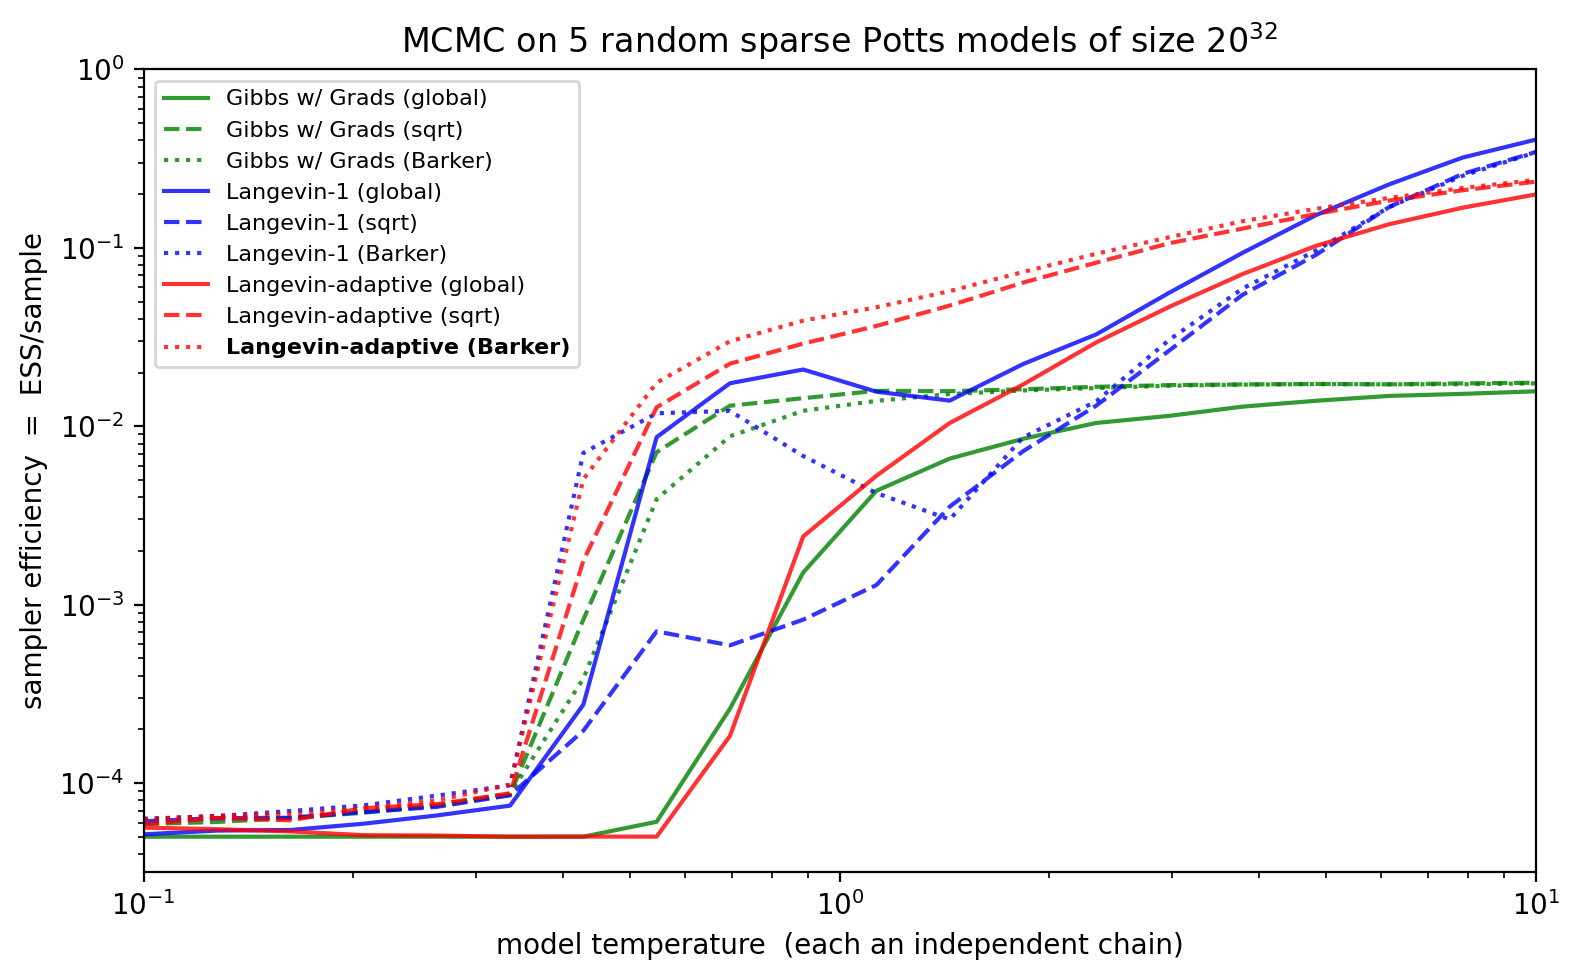

In [77]:
mcmc_styles = {
    "gibbs_with_gradients": ("Gibbs w/ Grads", "g"),
    "discrete_langevin": ("Langevin-1", "b"),
    "adaptive_langevin": ("Langevin-adaptive", "r"),
}
balance_styles = {
    "balance_sqrt": ("sqrt", "^", "--"),
    "balance_barker": ("Barker", "v", ":"),
    "balance_global": ("global", "o", "-"),
}
plt.figure(figsize=(8, 5))
totals = []
for p, k, mcmc, g in itertools.product(ps, ks, mcmcs, gs):
    g_name, marker, linestyle = balance_styles[g.__name__]
    mcmc_name, color = mcmc_styles[mcmc.__name__]
    label = label=f"{mcmc_name} ({g_name})"
    y = torch.tensor([np.mean([effs[p, k, g, mcmc, t, seed] for seed in seeds]) for t in ts])
    plt.plot(ts, y, alpha=0.8, color=color, linestyle=linestyle, label=label)
    totals.append(sum(y))
plt.xscale("log")
plt.yscale("log")
plt.ylim(None, 1)
plt.xlim(0.1, 10)
plt.xlabel("model temperature  (each an independent chain)")
plt.ylabel("sampler efficiency  =  ESS/sample")
plt.title(f"MCMC on {len(seeds)} random sparse Potts models of size ${ks[0]}^{{{ps[0]}}}$")
plt.tight_layout()
legend = plt.legend(loc="best", fontsize=8)
for t, total in zip(legend.get_texts(), totals):
    if total == max(totals):
        t.set_weight("bold")

## Acceptance rate over an annealing schedule

In [78]:
def trace_langevin(
    d: OneHotCategoricalPotts, schedule: Iterable[float]
) -> Dict[str, List[float]]:
    def make_logq(x, nbhd):
        p, k = x.shape
        logq = (nbhd / 2).clamp_(max=math.log(1e6))  # locally balance
        # Set step size so that q(x1[i] = x0[i]) > 1/2 for every i.
        logq += x * logq.exp().sum(-1).max().sub(1).clamp(min=1).log()
        logq -= logq.logsumexp(-1, True)  # normalize
        return logq
        
    # Initialize to random uniform.
    x0 = dist.OneHotCategorical(torch.ones(d.event_shape)).sample()
    logp0, nbhd0 = d.log_prob_nbhd(x0)

    trace = defaultdict(list)
    for temperature in schedule:
        # Propose.
        logq0 = make_logq(x0, nbhd0 / temperature)
        x1 = dist.OneHotCategorical(logits=logq0).sample()
        distance = round((x0 != x1).sum().div(2).item())
        if distance == 0:
            accept = True
        else:
            # Accept or reject.
            logp1, nbhd1 = d.log_prob_nbhd(x1)
            logq1 = make_logq(x1, nbhd1 / temperature)
            logq01 = torch.tensordot(logq0, x1)
            logq10 = torch.tensordot(logq1, x0)
            ratio = ((logp1 - logp0) / temperature + logq10 - logq01).exp()
            accept = bool(ratio > torch.rand(()))
            if accept:
                x0, logp0, nbhd0 = x1, logp1, nbhd1
        trace["temperature"].append(temperature)
        trace["accept"].append(accept)
        trace["distance"].append(distance)
        trace["logp"].append(float(logp0))

    assert all(len(v) == len(schedule) for v in trace.values())
    trace = {k: torch.tensor(v, dtype=torch.float) for k, v in trace.items()}
    return trace

In [79]:
def plot_trace(p, k, num_steps=1000, t_min=0.1, t_max=10.0):
    pyro.set_rng_seed(20220715)
    d = random_potts(p, k)
    schedule = torch.logspace(math.log10(t_max), math.log(t_min), num_steps).tolist()
    trace = trace_langevin(d, schedule)
    trace["speed"] = trace["distance"] * trace["accept"]

    plt.plot(figsize=(6, 4))
    radius = num_steps // 100
    kernel = torch.ones(radius) / radius
    for _ in range(2):
        kernel = convolve(kernel, kernel, mode="full")
    denom = convolve(torch.ones(num_steps), kernel, mode="same")
    temperature = trace.pop("temperature")
    for label, v in sorted(trace.items()):
        v = convolve(v, kernel, mode="same") / denom
        plt.plot(temperature.numpy(), v.numpy(), label=label, lw=1)
    plt.axhline(1, color="black", lw=1, ls="--", alpha=0.4, zorder=-1)
    plt.axhline(p, color="red", lw=1, ls="--", alpha=0.4, zorder=-1)
    plt.xlim(t_min, t_max)
    plt.ylim(0.1, None)
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc="best")
    plt.xlabel("temperature")
    plt.title(f"Annealing a Potts model of size ${k}^{{{p}}}$\n"
              f"logp max = {trace['logp'].max():0.4g}, final = {trace['logp'][-1]:0.4g}")
    plt.tight_layout()

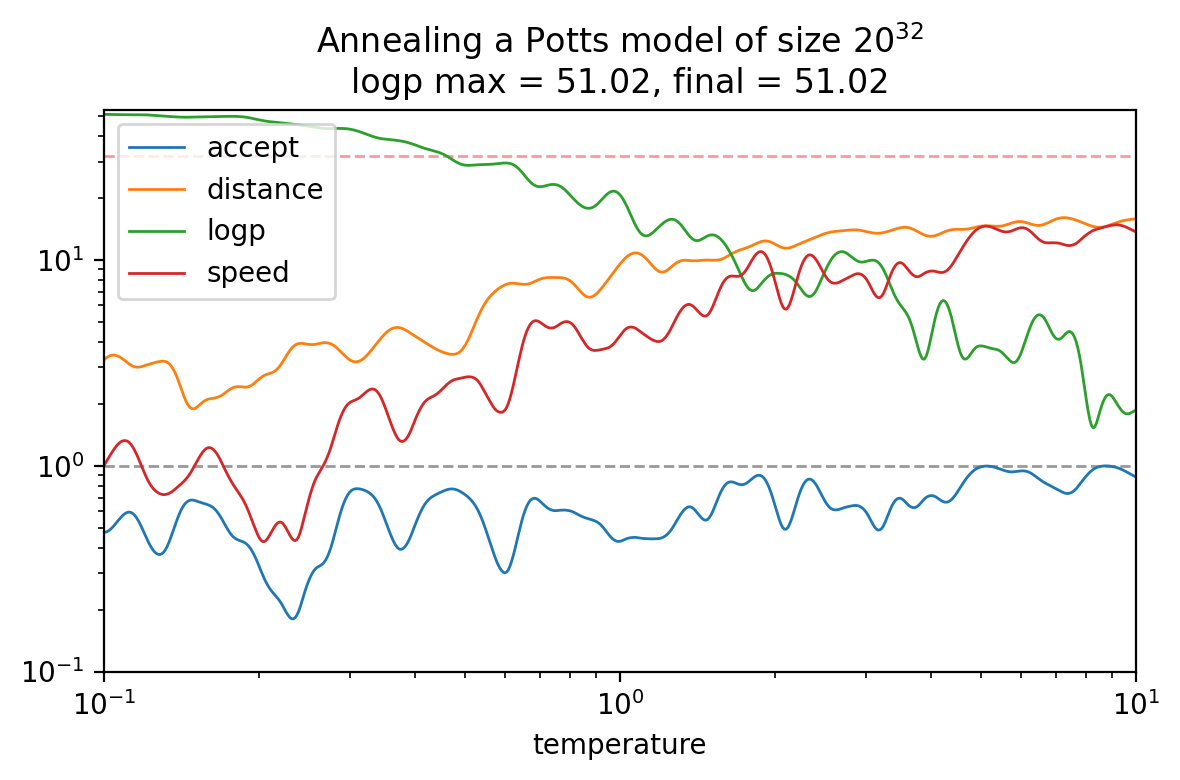

In [80]:
plot_trace(32, 20)

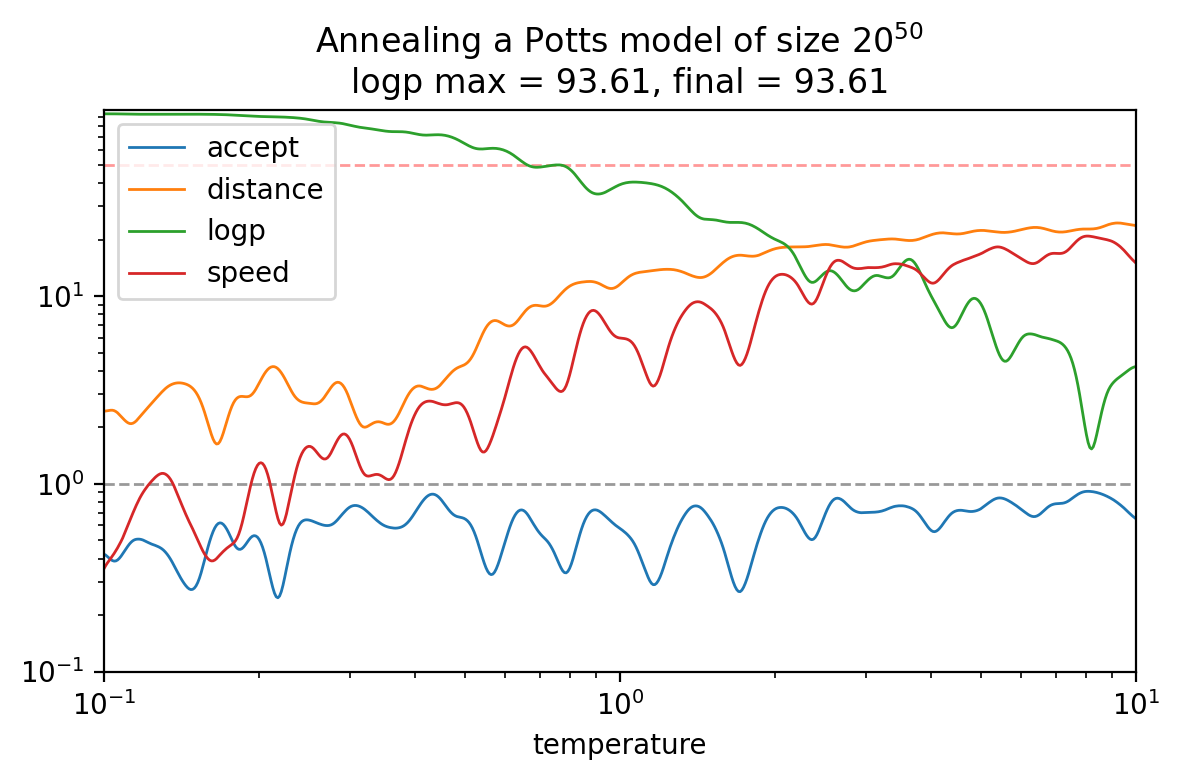

In [81]:
plot_trace(50, 20)

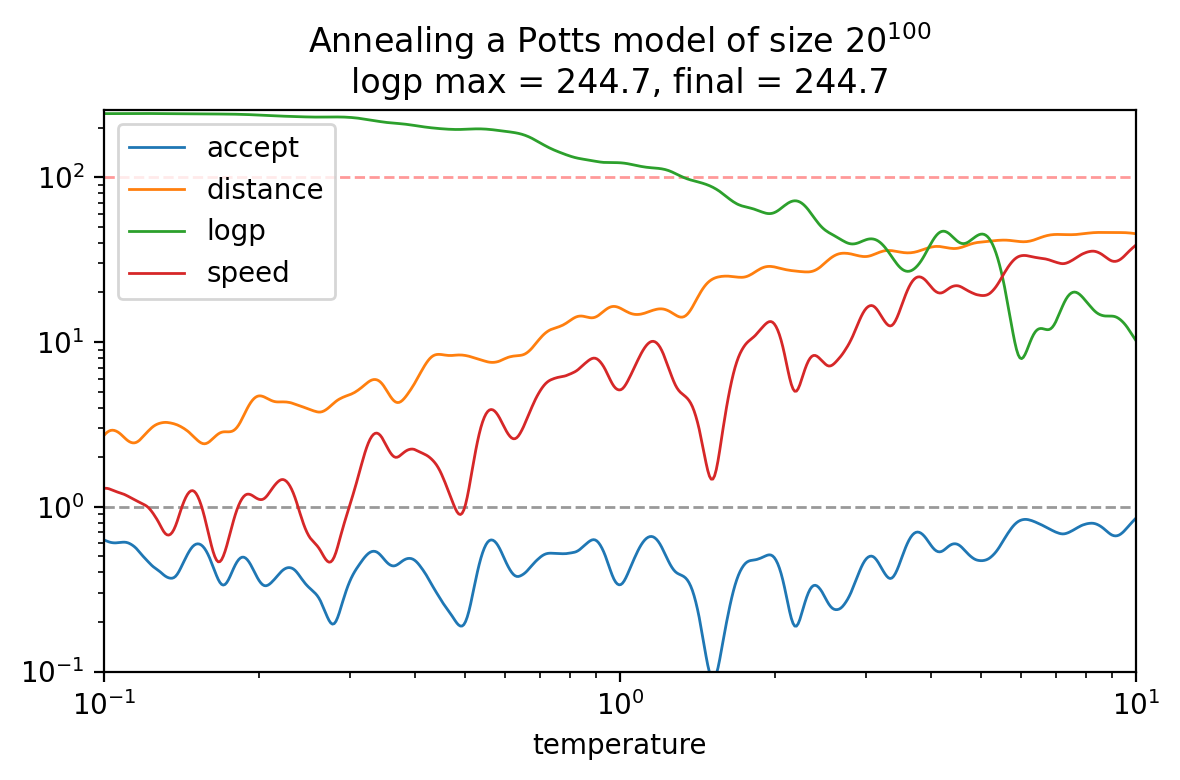

In [82]:
plot_trace(100, 20)

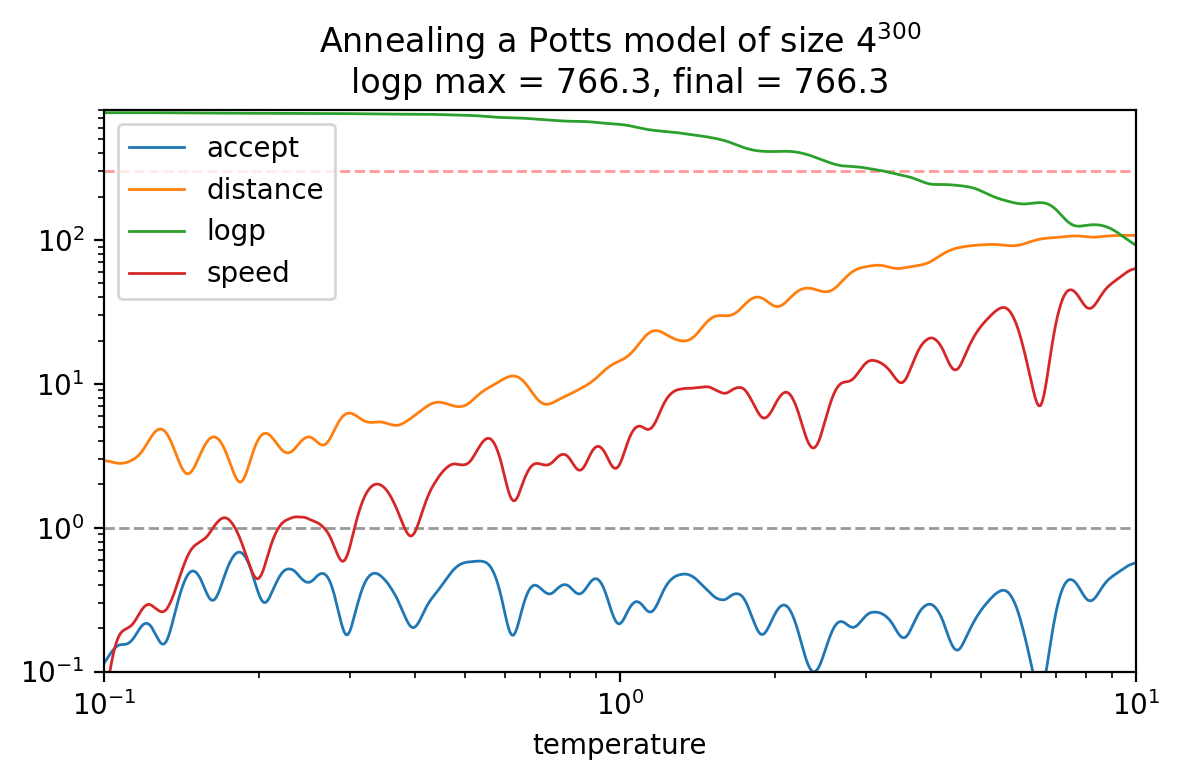

In [83]:
plot_trace(300, 4)